In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import mat73
import numpy as np
from tqdm import tqdm
import wandb
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

from scipy.signal import find_peaks
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import r2_score
import psutil
import os
import time

In [2]:
wandb.login()
# run = wandb.init(project="master-multicomponent-mri", name="3d-cnn-central-voxel")
run = wandb.init(project="master-multicomponent-mri", name="3d-cnn-central-voxel-improved")

wandb: Currently logged in as: tr-phan (trphan) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [ ]:
data = mat73.loadmat('../../data/training_data_T1_3D_9x9x32x47932_noise0.05.mat')
input_noisy_np = data['input_noisy']
input_clean_np = data['input']
ref_np = data['ref']

print("Shape of input data:", input_noisy_np.shape)
print("Shape of reference data:", ref_np.shape)

Shape of input data: (9, 9, 8, 47932)
Shape of reference data: (9, 9, 32, 47932)


In [4]:
nan_count_input_noisy_before = np.isnan(input_noisy_np).sum()
nan_count_ref_before = np.isnan(ref_np).sum()
print(f"NaN count in input_noisy before handling: {nan_count_input_noisy_before}")
print(f"NaN count in ref before handling: {nan_count_ref_before}")

NaN count in input_noisy before handling: 1635840
NaN count in ref before handling: 0


In [5]:
input_noisy_np = np.nan_to_num(input_noisy_np, nan=0.0)
nan_count_input_noisy_after = np.isnan(input_noisy_np).sum()
print(f"NaN count in input_noisy after handling: {nan_count_input_noisy_after}")

NaN count in input_noisy after handling: 0


In [ ]:
print("Input shape:", input_noisy_np.shape)
print("Reference shape:", ref_np.shape)

Input shape: (9, 9, 8, 47932)
Reference shape: (9, 9, 32, 47932)


In [ ]:
class T1PatchDataset(Dataset):
    def __init__(self, input_data, target_data):
        self.input_data = input_data
        self.target_data = target_data[:, :, 4, 4]  # center voxel

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        # adding channel dimension
        input_3d = self.input_data[idx].permute(1, 2, 0).unsqueeze(0)
        return input_3d, self.target_data[idx]

In [ ]:
class CentralVoxel3DCNN(nn.Module):
    def __init__(self):
        super(CentralVoxel3DCNN, self).__init__()
        
        # Input shape: [batch_size, 1, 9, 9, 8]
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(32)
        self.relu1 = nn.LeakyReLU(0.1)
        
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(64)
        self.relu2 = nn.LeakyReLU(0.1)
        
        self.conv3 = nn.Conv3d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm3d(128)
        self.relu3 = nn.LeakyReLU(0.1)
        
        # Global average pooling to reduce spatial and temporal dimensions
        self.global_avg_pool = nn.AdaptiveAvgPool3d(1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128, 256)
        self.fc_relu1 = nn.LeakyReLU(0.1)
        self.dropout1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(256, 128)
        self.fc_relu2 = nn.LeakyReLU(0.1)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(128, 32)

    def forward(self, x):
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.relu3(self.bn3(self.conv3(x)))
        
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        
        x = self.dropout1(self.fc_relu1(self.fc1(x)))
        x = self.dropout2(self.fc_relu2(self.fc2(x)))
        x = self.fc3(x)
        
        return x

In [ ]:
class EarlyStopping:
    def __init__(self, patience=15, min_delta=1e-6, path='saved_models/checkpoint.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)

In [ ]:
# Transpose the input and reference data to be (N, C, H, W) format
input_noisy_torch = np.transpose(input_noisy_np, (3, 2, 0, 1))
ref_torch = np.transpose(ref_np, (3, 2, 0, 1))

input_noisy_torch = torch.tensor(input_noisy_torch, dtype=torch.float32)
ref_torch = torch.tensor(ref_torch, dtype=torch.float32)

In [11]:
print("Input tensor shape:", input_noisy_torch.shape)
print("Reference tensor shape:", ref_torch.shape)

Input tensor shape: torch.Size([47932, 8, 9, 9])
Reference tensor shape: torch.Size([47932, 32, 9, 9])


In [ ]:
# Create Dataset
dataset = T1PatchDataset(input_noisy_torch, ref_torch)

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
sample_input, sample_target = dataset[0]
print("Sample input shape:", sample_input.shape)
print("Sample target shape:", sample_target.shape)

Sample input shape: torch.Size([1, 9, 9, 8])
Sample target shape: torch.Size([32])


In [ ]:
# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CentralVoxel3DCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)
early_stopping = EarlyStopping(patience=15, path='best_3dcnn_model.pt')

num_epochs = 200

d:\Proton Drive\My files\Schule\Master\Masterarbeit\project\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [15]:
# Log configuration
wandb.config.update({
    "learning_rate": 0.001,
    "batch_size": batch_size,
    "epochs": num_epochs,
    "architecture": "CentralVoxelCNN",
    "optimizer": "Adam",
    "loss_function": "MSELoss",
    "scheduler": "ReduceLROnPlateau",
    "early_stopping_patience": 15
})

In [16]:
# Training loop
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    progress_bar_train = tqdm(train_loader, desc=f'Epoch [{epoch+1}/{num_epochs}] Training')
    
    for inputs, targets in progress_bar_train:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        train_loss += loss.item()
        progress_bar_train.set_postfix({'loss': loss.item()})

    avg_train_loss = train_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    progress_bar_val = tqdm(val_loader, desc=f'Epoch [{epoch+1}/{num_epochs}] Validation')
    
    with torch.no_grad():
        for inputs, targets in progress_bar_val:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            progress_bar_val.set_postfix({'loss': loss.item()})

    avg_val_loss = val_loss / len(val_loader)

    # Learning rate scheduling
    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    # Early stopping
    early_stopping(avg_val_loss, model)

    # Logging
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "learning_rate": current_lr
    })

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}, LR: {current_lr}')

    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

print("Training finished")

Epoch [1/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 150.97it/s, loss=0.00314]


Epoch [1/200], Train Loss: 0.0032943716707328954, Val Loss: 0.00351573936175555, LR: 0.001


Epoch [2/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 159.00it/s, loss=0.00252]


Epoch [2/200], Train Loss: 0.002836694105062634, Val Loss: 0.0026078646707658965, LR: 0.001


Epoch [3/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 149.56it/s, loss=0.00288]


EarlyStopping counter: 1 out of 15
Epoch [3/200], Train Loss: 0.0027219586276138823, Val Loss: 0.0031385406525805595, LR: 0.001


Epoch [4/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 155.66it/s, loss=0.00271]


EarlyStopping counter: 2 out of 15
Epoch [4/200], Train Loss: 0.0026632898832516126, Val Loss: 0.0026709053587789335, LR: 0.001


Epoch [5/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 159.58it/s, loss=0.00255]


EarlyStopping counter: 3 out of 15
Epoch [5/200], Train Loss: 0.002617800321507578, Val Loss: 0.0027257940266281365, LR: 0.001


Epoch [6/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 167.46it/s, loss=0.00267]


EarlyStopping counter: 4 out of 15
Epoch [6/200], Train Loss: 0.0025777024814548593, Val Loss: 0.002650799195592602, LR: 0.001


Epoch [7/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 176.91it/s, loss=0.00233]


Epoch [7/200], Train Loss: 0.0025224646518472583, Val Loss: 0.0024123902471425633, LR: 0.001


Epoch [8/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 179.21it/s, loss=0.00233]


EarlyStopping counter: 1 out of 15
Epoch [8/200], Train Loss: 0.0024974955329283453, Val Loss: 0.0024737146915867923, LR: 0.001


Epoch [9/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 166.40it/s, loss=0.00252]


EarlyStopping counter: 2 out of 15
Epoch [9/200], Train Loss: 0.002481856712062533, Val Loss: 0.0025821134339397154, LR: 0.001


Epoch [10/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 148.75it/s, loss=0.00228]


Epoch [10/200], Train Loss: 0.0024447526086199406, Val Loss: 0.002367518402946492, LR: 0.001


Epoch [11/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 162.04it/s, loss=0.00229]


EarlyStopping counter: 1 out of 15
Epoch [11/200], Train Loss: 0.0024310154776321724, Val Loss: 0.0023699684619593125, LR: 0.001


Epoch [12/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 164.51it/s, loss=0.00249]


EarlyStopping counter: 2 out of 15
Epoch [12/200], Train Loss: 0.0024047108471859247, Val Loss: 0.0024471501680091022, LR: 0.001


Epoch [13/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 165.07it/s, loss=0.00239]


Epoch [13/200], Train Loss: 0.0023949971242109313, Val Loss: 0.0023497734024810293, LR: 0.001


Epoch [14/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 154.02it/s, loss=0.00236]


Epoch [14/200], Train Loss: 0.0023664105631178243, Val Loss: 0.0023461843887344004, LR: 0.001


Epoch [15/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 139.60it/s, loss=0.00221]


Epoch [15/200], Train Loss: 0.0023616423677109803, Val Loss: 0.002178035983039687, LR: 0.001


Epoch [16/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 171.40it/s, loss=0.00233]


EarlyStopping counter: 1 out of 15
Epoch [16/200], Train Loss: 0.0023412410519085824, Val Loss: 0.002391702299937606, LR: 0.001


Epoch [17/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 151.68it/s, loss=0.00226]


EarlyStopping counter: 2 out of 15
Epoch [17/200], Train Loss: 0.0023242034627279887, Val Loss: 0.0023758308449760078, LR: 0.001


Epoch [18/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 156.34it/s, loss=0.00271]


EarlyStopping counter: 3 out of 15
Epoch [18/200], Train Loss: 0.0023082227698372057, Val Loss: 0.002636486574386557, LR: 0.001


Epoch [19/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 148.97it/s, loss=0.00222]


EarlyStopping counter: 4 out of 15
Epoch [19/200], Train Loss: 0.002301146649212266, Val Loss: 0.0022365949869466327, LR: 0.001


Epoch [20/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 154.12it/s, loss=0.00214]


EarlyStopping counter: 5 out of 15
Epoch [20/200], Train Loss: 0.002286091055527019, Val Loss: 0.0021930315376569825, LR: 0.001


Epoch [21/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 151.14it/s, loss=0.00214]


EarlyStopping counter: 6 out of 15
Epoch [21/200], Train Loss: 0.002282253458009412, Val Loss: 0.00223055677410836, LR: 0.001


Epoch [22/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 161.64it/s, loss=0.00211]


Epoch [22/200], Train Loss: 0.002263261659730536, Val Loss: 0.002125395620241761, LR: 0.001


Epoch [23/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 149.19it/s, loss=0.00209]


EarlyStopping counter: 1 out of 15
Epoch [23/200], Train Loss: 0.0022476248025971777, Val Loss: 0.002172240395254145, LR: 0.001


Epoch [24/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 147.84it/s, loss=0.00213]


Epoch [24/200], Train Loss: 0.0022523724413864936, Val Loss: 0.002106827941412727, LR: 0.001


Epoch [25/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 154.97it/s, loss=0.00213]


Epoch [25/200], Train Loss: 0.002226307747187093, Val Loss: 0.0020901677253035208, LR: 0.001


Epoch [26/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 172.86it/s, loss=0.00222]


EarlyStopping counter: 1 out of 15
Epoch [26/200], Train Loss: 0.0022274357449108113, Val Loss: 0.0022119778053214154, LR: 0.001


Epoch [27/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 176.70it/s, loss=0.00223]


EarlyStopping counter: 2 out of 15
Epoch [27/200], Train Loss: 0.002209090196605151, Val Loss: 0.0022572267707437277, LR: 0.001


Epoch [28/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 160.86it/s, loss=0.00215]


EarlyStopping counter: 3 out of 15
Epoch [28/200], Train Loss: 0.00220350286962154, Val Loss: 0.0022024898052526018, LR: 0.001


Epoch [29/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 151.43it/s, loss=0.00218]


EarlyStopping counter: 4 out of 15
Epoch [29/200], Train Loss: 0.0022037152718985455, Val Loss: 0.002145533135626465, LR: 0.001


Epoch [30/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 153.75it/s, loss=0.0021] 


Epoch [30/200], Train Loss: 0.0021914025590134166, Val Loss: 0.002064317490439862, LR: 0.001


Epoch [31/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 150.77it/s, loss=0.00203]


EarlyStopping counter: 1 out of 15
Epoch [31/200], Train Loss: 0.002188522338595552, Val Loss: 0.0021126836996215085, LR: 0.001


Epoch [32/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 147.63it/s, loss=0.00221]


EarlyStopping counter: 2 out of 15
Epoch [32/200], Train Loss: 0.002183947098480227, Val Loss: 0.002115575699135661, LR: 0.001


Epoch [33/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 147.20it/s, loss=0.00231]


EarlyStopping counter: 3 out of 15
Epoch [33/200], Train Loss: 0.002172600586976235, Val Loss: 0.0023309628440377613, LR: 0.001


Epoch [34/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 148.98it/s, loss=0.00208]


EarlyStopping counter: 4 out of 15
Epoch [34/200], Train Loss: 0.0021598595299292356, Val Loss: 0.0020963061057652035, LR: 0.001


Epoch [35/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 148.31it/s, loss=0.00208]


Epoch [35/200], Train Loss: 0.002153430413454771, Val Loss: 0.0020232790786152083, LR: 0.001


Epoch [36/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 146.72it/s, loss=0.00229]


EarlyStopping counter: 1 out of 15
Epoch [36/200], Train Loss: 0.0021561258391011506, Val Loss: 0.002215998201475789, LR: 0.001


Epoch [37/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 148.75it/s, loss=0.00206]


EarlyStopping counter: 2 out of 15
Epoch [37/200], Train Loss: 0.002142559336110329, Val Loss: 0.0020272735203616323, LR: 0.001


Epoch [38/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 151.04it/s, loss=0.00216]


EarlyStopping counter: 3 out of 15
Epoch [38/200], Train Loss: 0.002138890951949482, Val Loss: 0.002171127606804172, LR: 0.001


Epoch [39/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 148.85it/s, loss=0.00207]


EarlyStopping counter: 4 out of 15
Epoch [39/200], Train Loss: 0.0021335983441288895, Val Loss: 0.0020361949852667747, LR: 0.001


Epoch [40/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 165.05it/s, loss=0.00222]


EarlyStopping counter: 5 out of 15
Epoch [40/200], Train Loss: 0.002130179901335699, Val Loss: 0.0021531839823971193, LR: 0.001


Epoch [41/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 158.78it/s, loss=0.00218]


EarlyStopping counter: 6 out of 15
Epoch [41/200], Train Loss: 0.0021245410279758896, Val Loss: 0.0020644463699621457, LR: 0.001


Epoch [42/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 163.02it/s, loss=0.00206]


Epoch [42/200], Train Loss: 0.0021195992388917755, Val Loss: 0.002019128855317831, LR: 0.001


Epoch [43/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 174.95it/s, loss=0.00215]


EarlyStopping counter: 1 out of 15
Epoch [43/200], Train Loss: 0.0021204786935898785, Val Loss: 0.0021063836733810604, LR: 0.001


Epoch [44/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 174.09it/s, loss=0.00211]


EarlyStopping counter: 2 out of 15
Epoch [44/200], Train Loss: 0.0021113419505612305, Val Loss: 0.002099459539167583, LR: 0.001


Epoch [45/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 179.90it/s, loss=0.00208]


EarlyStopping counter: 3 out of 15
Epoch [45/200], Train Loss: 0.002110019865989064, Val Loss: 0.002046656977230062, LR: 0.001


Epoch [46/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 175.79it/s, loss=0.00208]


EarlyStopping counter: 4 out of 15
Epoch [46/200], Train Loss: 0.0020941721192017817, Val Loss: 0.0020668550751482447, LR: 0.001


Epoch [47/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 177.24it/s, loss=0.00218]


EarlyStopping counter: 5 out of 15
Epoch [47/200], Train Loss: 0.0020956147914209093, Val Loss: 0.002030240814977636, LR: 0.001


Epoch [48/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 174.05it/s, loss=0.00205]


EarlyStopping counter: 6 out of 15
Epoch [48/200], Train Loss: 0.0020953399094287306, Val Loss: 0.002090737981876979, LR: 0.001


Epoch [49/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 170.73it/s, loss=0.00232]


EarlyStopping counter: 7 out of 15
Epoch [49/200], Train Loss: 0.0020915664412314073, Val Loss: 0.0024174625899953148, LR: 0.001


Epoch [50/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 171.65it/s, loss=0.00194]


EarlyStopping counter: 8 out of 15
Epoch [50/200], Train Loss: 0.002075875630058969, Val Loss: 0.002042860658839345, LR: 0.001


Epoch [51/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 172.13it/s, loss=0.0021] 


EarlyStopping counter: 9 out of 15
Epoch [51/200], Train Loss: 0.002082230331531415, Val Loss: 0.002021934177416066, LR: 0.001


Epoch [52/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 173.50it/s, loss=0.00206]


Epoch [52/200], Train Loss: 0.002075588898927284, Val Loss: 0.0019805387523956597, LR: 0.001


Epoch [53/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 173.59it/s, loss=0.00208]


EarlyStopping counter: 1 out of 15
Epoch [53/200], Train Loss: 0.002061909383822543, Val Loss: 0.001998269610727827, LR: 0.001


Epoch [54/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 160.15it/s, loss=0.00208]


EarlyStopping counter: 2 out of 15
Epoch [54/200], Train Loss: 0.0020628985077685985, Val Loss: 0.0019942757293271523, LR: 0.001


Epoch [55/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 161.95it/s, loss=0.00222]


EarlyStopping counter: 3 out of 15
Epoch [55/200], Train Loss: 0.0020613503149555373, Val Loss: 0.002210843324040373, LR: 0.001


Epoch [56/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 173.44it/s, loss=0.00207]


EarlyStopping counter: 4 out of 15
Epoch [56/200], Train Loss: 0.002058416816095511, Val Loss: 0.00205278163542971, LR: 0.001


Epoch [57/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 169.13it/s, loss=0.00205]


EarlyStopping counter: 5 out of 15
Epoch [57/200], Train Loss: 0.0020524793044508745, Val Loss: 0.002022621740276615, LR: 0.001


Epoch [58/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 153.07it/s, loss=0.00206]


EarlyStopping counter: 6 out of 15
Epoch [58/200], Train Loss: 0.0020447072710764284, Val Loss: 0.0019936483555162946, LR: 0.001


Epoch [59/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 152.70it/s, loss=0.00224]


EarlyStopping counter: 7 out of 15
Epoch [59/200], Train Loss: 0.0020478616860539964, Val Loss: 0.002093522322829813, LR: 0.001


Epoch [60/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 163.73it/s, loss=0.00219]


EarlyStopping counter: 8 out of 15
Epoch [60/200], Train Loss: 0.0020472056998793657, Val Loss: 0.002182354776499172, LR: 0.001


Epoch [61/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 158.10it/s, loss=0.00238]


EarlyStopping counter: 9 out of 15
Epoch [61/200], Train Loss: 0.002042811306309886, Val Loss: 0.00212908808219557, LR: 0.001


Epoch [62/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 154.24it/s, loss=0.00216]


EarlyStopping counter: 10 out of 15
Epoch [62/200], Train Loss: 0.002037838198981869, Val Loss: 0.002077129840229948, LR: 0.001


Epoch [63/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 155.92it/s, loss=0.00201]


EarlyStopping counter: 11 out of 15
Epoch [63/200], Train Loss: 0.0020356790294560295, Val Loss: 0.0020121952805978558, LR: 0.0005


Epoch [64/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 159.25it/s, loss=0.00197]


Epoch [64/200], Train Loss: 0.001966443908168003, Val Loss: 0.001933299247175455, LR: 0.0005


Epoch [65/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 171.61it/s, loss=0.002]  


EarlyStopping counter: 1 out of 15
Epoch [65/200], Train Loss: 0.001955185069818981, Val Loss: 0.001971662160164366, LR: 0.0005


Epoch [66/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 140.74it/s, loss=0.00209]


Epoch [66/200], Train Loss: 0.0019557912445937594, Val Loss: 0.0019265729483837883, LR: 0.0005


Epoch [67/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 149.38it/s, loss=0.00195]


EarlyStopping counter: 1 out of 15
Epoch [67/200], Train Loss: 0.0019508838304318488, Val Loss: 0.0019511821602160731, LR: 0.0005


Epoch [68/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 147.85it/s, loss=0.00199]


Epoch [68/200], Train Loss: 0.001942264796428693, Val Loss: 0.0019147847204779584, LR: 0.0005


Epoch [69/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 153.88it/s, loss=0.00203]


Epoch [69/200], Train Loss: 0.0019344176470379656, Val Loss: 0.0019057634938508272, LR: 0.0005


Epoch [70/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 154.49it/s, loss=0.002]  


EarlyStopping counter: 1 out of 15
Epoch [70/200], Train Loss: 0.0019329105402963857, Val Loss: 0.0019448365077065924, LR: 0.0005


Epoch [71/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 148.37it/s, loss=0.00206]


EarlyStopping counter: 2 out of 15
Epoch [71/200], Train Loss: 0.0019341656734468415, Val Loss: 0.001987789513853689, LR: 0.0005


Epoch [72/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 143.27it/s, loss=0.00206]


EarlyStopping counter: 3 out of 15
Epoch [72/200], Train Loss: 0.0019314755976665766, Val Loss: 0.001925460099397848, LR: 0.0005


Epoch [73/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 153.74it/s, loss=0.00201]


EarlyStopping counter: 4 out of 15
Epoch [73/200], Train Loss: 0.001924734763839903, Val Loss: 0.001981320440924416, LR: 0.0005


Epoch [74/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 157.13it/s, loss=0.002]  


Epoch [74/200], Train Loss: 0.0019221497150526071, Val Loss: 0.001896863142804553, LR: 0.0005


Epoch [75/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 152.68it/s, loss=0.00203]


EarlyStopping counter: 1 out of 15
Epoch [75/200], Train Loss: 0.001922546325561901, Val Loss: 0.0019345846741149822, LR: 0.0005


Epoch [76/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 169.02it/s, loss=0.00202]


EarlyStopping counter: 2 out of 15
Epoch [76/200], Train Loss: 0.0019173569175958013, Val Loss: 0.0019208875911620757, LR: 0.0005


Epoch [77/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 158.68it/s, loss=0.00198]


EarlyStopping counter: 3 out of 15
Epoch [77/200], Train Loss: 0.0019143504957901314, Val Loss: 0.001909199917378525, LR: 0.0005


Epoch [78/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 168.93it/s, loss=0.00198]


EarlyStopping counter: 4 out of 15
Epoch [78/200], Train Loss: 0.001909630003501661, Val Loss: 0.001927561357927819, LR: 0.0005


Epoch [79/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 167.36it/s, loss=0.00208]


EarlyStopping counter: 5 out of 15
Epoch [79/200], Train Loss: 0.0019125298369908705, Val Loss: 0.0019298925817323228, LR: 0.0005


Epoch [80/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 158.12it/s, loss=0.00199]


EarlyStopping counter: 6 out of 15
Epoch [80/200], Train Loss: 0.001911643769708462, Val Loss: 0.0019456177049626906, LR: 0.0005


Epoch [81/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 138.43it/s, loss=0.00197]


EarlyStopping counter: 7 out of 15
Epoch [81/200], Train Loss: 0.001906133638500857, Val Loss: 0.001913920594379306, LR: 0.0005


Epoch [82/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 148.43it/s, loss=0.00192]


Epoch [82/200], Train Loss: 0.0019041790725896136, Val Loss: 0.001892660295125097, LR: 0.0005


Epoch [83/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 155.34it/s, loss=0.00209]


EarlyStopping counter: 1 out of 15
Epoch [83/200], Train Loss: 0.0019007662179258962, Val Loss: 0.001959371264092624, LR: 0.0005


Epoch [84/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 143.73it/s, loss=0.00207]


EarlyStopping counter: 2 out of 15
Epoch [84/200], Train Loss: 0.0019018322966682414, Val Loss: 0.0020607935761411986, LR: 0.0005


Epoch [85/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 159.64it/s, loss=0.002]  


EarlyStopping counter: 3 out of 15
Epoch [85/200], Train Loss: 0.001896309788765696, Val Loss: 0.001988194671769937, LR: 0.0005


Epoch [86/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 159.73it/s, loss=0.00198]


EarlyStopping counter: 4 out of 15
Epoch [86/200], Train Loss: 0.0018915906162389243, Val Loss: 0.001929691636469215, LR: 0.0005


Epoch [87/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 159.18it/s, loss=0.00201]


EarlyStopping counter: 5 out of 15
Epoch [87/200], Train Loss: 0.0018890116458836323, Val Loss: 0.001910396763899674, LR: 0.0005


Epoch [88/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 176.50it/s, loss=0.00203]


EarlyStopping counter: 6 out of 15
Epoch [88/200], Train Loss: 0.0018892444183196252, Val Loss: 0.0019331353856250643, LR: 0.0005


Epoch [89/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 175.31it/s, loss=0.00198]


EarlyStopping counter: 7 out of 15
Epoch [89/200], Train Loss: 0.0018820594790546845, Val Loss: 0.0019190743976893524, LR: 0.0005


Epoch [90/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 177.06it/s, loss=0.0021] 


EarlyStopping counter: 8 out of 15
Epoch [90/200], Train Loss: 0.0018793649519405638, Val Loss: 0.0019359627241889636, LR: 0.0005


Epoch [91/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 166.45it/s, loss=0.0021] 


EarlyStopping counter: 9 out of 15
Epoch [91/200], Train Loss: 0.0018800122909791146, Val Loss: 0.001959276149670283, LR: 0.0005


Epoch [92/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 162.40it/s, loss=0.00203]


EarlyStopping counter: 10 out of 15
Epoch [92/200], Train Loss: 0.0018796470604138448, Val Loss: 0.0019299447482141357, LR: 0.0005


Epoch [93/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 177.23it/s, loss=0.00203]


EarlyStopping counter: 11 out of 15
Epoch [93/200], Train Loss: 0.0018726079288171604, Val Loss: 0.002001301487907767, LR: 0.00025


Epoch [94/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 171.30it/s, loss=0.002]  


Epoch [94/200], Train Loss: 0.0018320295981053883, Val Loss: 0.0018882391857914626, LR: 0.00025


Epoch [95/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 167.68it/s, loss=0.00197]


EarlyStopping counter: 1 out of 15
Epoch [95/200], Train Loss: 0.0018208935105940326, Val Loss: 0.0019059545577814181, LR: 0.00025


Epoch [96/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 168.63it/s, loss=0.002]  


EarlyStopping counter: 2 out of 15
Epoch [96/200], Train Loss: 0.0018228200083831325, Val Loss: 0.001896574606653303, LR: 0.00025


Epoch [97/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 176.96it/s, loss=0.00195]


Epoch [97/200], Train Loss: 0.0018182172222683827, Val Loss: 0.0018869642758121094, LR: 0.00025


Epoch [98/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 177.65it/s, loss=0.00201]


EarlyStopping counter: 1 out of 15
Epoch [98/200], Train Loss: 0.0018184857091788824, Val Loss: 0.0019125969762293, LR: 0.00025


Epoch [99/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 152.21it/s, loss=0.002]  


EarlyStopping counter: 2 out of 15
Epoch [99/200], Train Loss: 0.0018158823635894806, Val Loss: 0.001932137096300721, LR: 0.00025


Epoch [100/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 153.71it/s, loss=0.00197]


EarlyStopping counter: 3 out of 15
Epoch [100/200], Train Loss: 0.0018131326018677404, Val Loss: 0.001896752514100323, LR: 0.00025


Epoch [101/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 176.46it/s, loss=0.002]  


EarlyStopping counter: 4 out of 15
Epoch [101/200], Train Loss: 0.0018166228234379864, Val Loss: 0.0019065189897082746, LR: 0.00025


Epoch [102/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 171.63it/s, loss=0.00205]


EarlyStopping counter: 5 out of 15
Epoch [102/200], Train Loss: 0.0018130195821868256, Val Loss: 0.0019183181963550548, LR: 0.00025


Epoch [103/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 159.80it/s, loss=0.00199]


EarlyStopping counter: 6 out of 15
Epoch [103/200], Train Loss: 0.0018106590748842185, Val Loss: 0.001889871087235709, LR: 0.00025


Epoch [104/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 139.91it/s, loss=0.00198]


EarlyStopping counter: 7 out of 15
Epoch [104/200], Train Loss: 0.0018025031850750868, Val Loss: 0.001904613070655614, LR: 0.00025


Epoch [105/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 142.71it/s, loss=0.00204]


EarlyStopping counter: 8 out of 15
Epoch [105/200], Train Loss: 0.0018029282622349758, Val Loss: 0.0019159843089679876, LR: 0.00025


Epoch [106/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 153.11it/s, loss=0.00197]


EarlyStopping counter: 9 out of 15
Epoch [106/200], Train Loss: 0.0018048599959972003, Val Loss: 0.0018877792971519133, LR: 0.00025


Epoch [107/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 155.14it/s, loss=0.00195]


EarlyStopping counter: 10 out of 15
Epoch [107/200], Train Loss: 0.0017979012716871996, Val Loss: 0.0019141057622618974, LR: 0.00025


Epoch [108/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 162.84it/s, loss=0.002]  


EarlyStopping counter: 11 out of 15
Epoch [108/200], Train Loss: 0.0017982592039819186, Val Loss: 0.0019048111063117781, LR: 0.000125


Epoch [109/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 158.82it/s, loss=0.00193]


EarlyStopping counter: 12 out of 15
Epoch [109/200], Train Loss: 0.0017710996663663535, Val Loss: 0.0018972792608353, LR: 0.000125


Epoch [110/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 138.33it/s, loss=0.00195]


EarlyStopping counter: 13 out of 15
Epoch [110/200], Train Loss: 0.0017706190563815955, Val Loss: 0.00189882128033787, LR: 0.000125


Epoch [111/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 144.33it/s, loss=0.002]  


EarlyStopping counter: 14 out of 15
Epoch [111/200], Train Loss: 0.001771116847715651, Val Loss: 0.001887817387469113, LR: 0.000125


Epoch [112/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 165.59it/s, loss=0.00206]

EarlyStopping counter: 15 out of 15
Epoch [112/200], Train Loss: 0.0017652039266734694, Val Loss: 0.0018947321696517368, LR: 0.000125
Early stopping triggered
Training finished


In [17]:
def calculate_psnr(target, prediction):
    """Calculate Peak Signal-to-Noise Ratio"""
    mse = np.mean((target - prediction) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = np.max(target)
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def calculate_peak_metrics(target, prediction, prominence=0.1):
    """Calculate peak detection accuracy"""
    peak_metrics = {'true_peaks': 0, 'predicted_peaks': 0, 'matching_peaks': 0}
    
    for i in range(len(target)):
        true_peaks, _ = find_peaks(target[i], prominence=prominence)
        pred_peaks, _ = find_peaks(prediction[i], prominence=prominence)
        
        # Count matching peaks (within ±1 index)
        matches = 0
        for tp in true_peaks:
            for pp in pred_peaks:
                if abs(tp - pp) <= 1:
                    matches += 1
                    break
        
        peak_metrics['true_peaks'] += len(true_peaks)
        peak_metrics['predicted_peaks'] += len(pred_peaks)
        peak_metrics['matching_peaks'] += matches
    
    return peak_metrics

def measure_inference_time(model, input_tensor, device, num_iterations=100):
    """Measure average inference time"""
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_iterations):
            _ = model(input_tensor.to(device))
    end_time = time.time()
    return (end_time - start_time) / num_iterations

def count_parameters(model):
    """Count number of trainable parameters"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def measure_memory_usage():
    """Measure current memory usage"""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024  # Convert to MB

def evaluate_model_metrics(model, val_loader, device):
    """Evaluate all model metrics"""
    model.eval()
    metrics = {}
    
    # Get sample input for inference time measurement
    sample_input, _ = next(iter(val_loader))
    metrics['inference_time'] = measure_inference_time(model, sample_input, device)
    
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            
            # Convert to numpy for metric calculation
            targets_np = targets.cpu().numpy()
            outputs_np = outputs.cpu().numpy()
            
            all_targets.append(targets_np)
            all_predictions.append(outputs_np)
    
    # Concatenate all batches
    all_targets = np.concatenate(all_targets)
    all_predictions = np.concatenate(all_predictions)
    
    # Calculate metrics
    metrics['mse'] = np.mean((all_targets - all_predictions) ** 2)
    metrics['mae'] = np.mean(np.abs(all_targets - all_predictions))
    metrics['psnr'] = calculate_psnr(all_targets, all_predictions)
    metrics['r2_score'] = r2_score(all_targets.flatten(), all_predictions.flatten())
    metrics['peak_metrics'] = calculate_peak_metrics(all_targets, all_predictions)
    metrics['memory_usage'] = measure_memory_usage()
    metrics['num_parameters'] = count_parameters(model)
    
    return metrics

In [ ]:
model.eval()
final_metrics = evaluate_model_metrics(model, val_loader, device)

wandb.log({
    "final_mse": final_metrics['mse'],
    "final_mae": final_metrics['mae'],
    "final_psnr": final_metrics['psnr'],
    "final_r2_score": final_metrics['r2_score'],
    "peak_detection_accuracy": final_metrics['peak_metrics']['matching_peaks'] / 
                             final_metrics['peak_metrics']['true_peaks'],
    "inference_time_ms": final_metrics['inference_time'] * 1000,
    "memory_usage_mb": final_metrics['memory_usage'],
    "model_parameters": final_metrics['num_parameters']
})

print("\nFinal Model Evaluation:")
print(f"MSE: {final_metrics['mse']:.6f}")
print(f"MAE: {final_metrics['mae']:.6f}")
print(f"PSNR: {final_metrics['psnr']:.2f} dB")
print(f"R² Score: {final_metrics['r2_score']:.4f}")
print(f"Peak Detection Accuracy: {final_metrics['peak_metrics']['matching_peaks'] / final_metrics['peak_metrics']['true_peaks']:.2%}")
print(f"Average Inference Time: {final_metrics['inference_time']*1000:.2f} ms")
print(f"Memory Usage: {final_metrics['memory_usage']:.1f} MB")
print(f"Number of Parameters: {final_metrics['num_parameters']:,}")


Final Model Evaluation:
MSE: 0.001895
MAE: 0.023451
PSNR: 27.15 dB
R² Score: 0.5560
Peak Detection Accuracy: 42.47%
Average Inference Time: 4.20 ms
Memory Usage: 2331.0 MB
Number of Parameters: 348,064


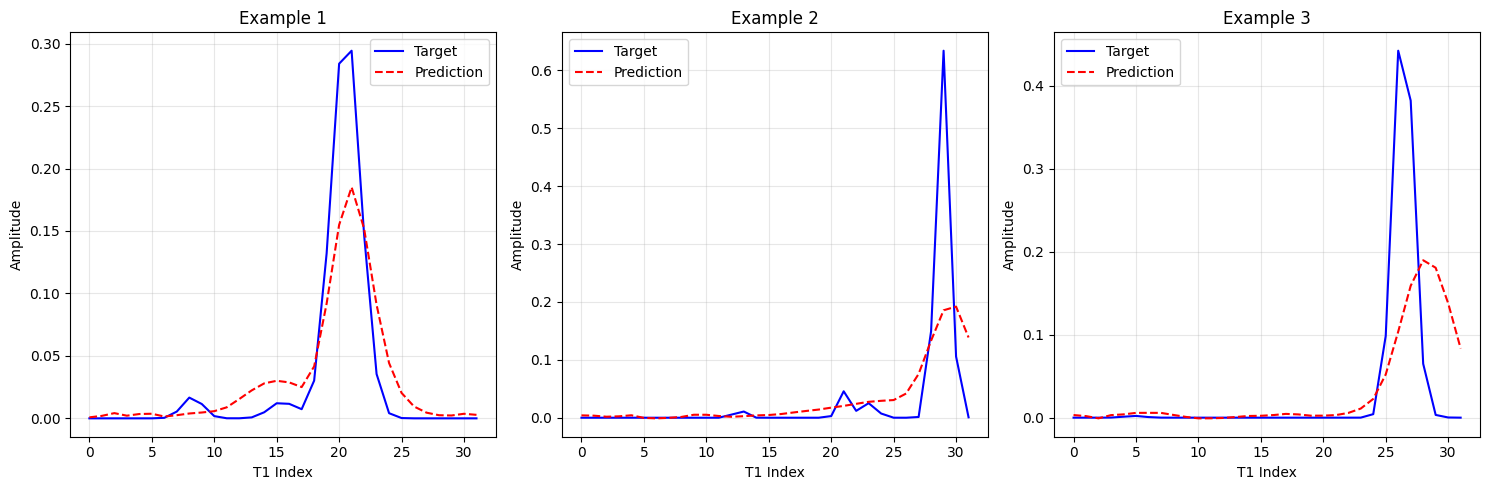

Test MSE: 0.001662
Test MAE: 0.022607


In [ ]:
inputs, targets = next(iter(val_loader))
inputs, targets = inputs.to(device), targets.to(device)

with torch.no_grad():
    outputs = model(inputs)

inputs = inputs.cpu().numpy()
targets = targets.cpu().numpy()
outputs = outputs.cpu().numpy()

plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.plot(targets[i], 'b-', label='Target')
    plt.plot(outputs[i], 'r--', label='Prediction')
    plt.title(f'Example {i+1}')
    plt.xlabel('T1 Index')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

mse = np.mean((targets - outputs)**2)
mae = np.mean(np.abs(targets - outputs))
print(f"Test MSE: {mse:.6f}")
print(f"Test MAE: {mae:.6f}")

In [20]:
wandb.finish()

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇███
final_mae,▁
final_mse,▁
final_psnr,▁
final_r2_score,▁
inference_time_ms,▁
learning_rate,██████████████████████▄▄▄▄▄▄▄▄▄▂▂▂▂▂▂▂▂▁
memory_usage_mb,▁
model_parameters,▁
peak_detection_accuracy,▁
train_loss,█▇▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
